Load Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('/content/male_players (legacy).csv', na_values='-')

<ipython-input-2-76370eeeea68>:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/male_players (legacy).csv', na_values='-')


Data Preprocessing



In [16]:
# Features with more than 40% missing values should be dropped
L_more = []
L_less = []
for i in df.columns:
    if (df[i].isnull().sum() < (0.4 * df.shape[0])):
        L_less.append(i)
    else:
        L_more.append(i)

In [17]:

df = df[L_less]

In [18]:
# **Filter African Players Only**
african_countries = [
    "Nigeria", "Ghana", "Senegal", "Ivory Coast", "Cameroon",
    "South Africa", "Egypt", "Morocco", "Algeria", "Kenya",
    "Uganda", "Zambia", "Tanzania", "DR Congo", "Tunisia"
]


In [7]:
# Filter African Players Only
african_countries = [
    "Nigeria", "Ghana", "Senegal", "Ivory Coast", "Cameroon",
    "South Africa", "Egypt", "Morocco", "Algeria", "Kenya",
    "Uganda", "Zambia", "Tanzania", "DR Congo", "Tunisia"
]

In [19]:
df = df[df['nationality_name'].isin(african_countries)]

In [20]:
# Check if the dataset has any African players left
if df.empty:
    raise ValueError("No African players found in the dataset after filtering!")

In [21]:
# Selecting selient features
# Separating the data
import numpy as np
numeric_data = df.select_dtypes(include=np.number)
non_numeric = df.select_dtypes(include = ['object'])

In [22]:
# Drop irrelevant numerical-columns
numeric_data.drop(['player_id', 'fifa_version', 'fifa_update', 'club_team_id', 'club_jersey_number', 'club_contract_valid_until_year', 'nationality_id'], axis=1, inplace=True)

In [23]:
# Drop irrelevant non-numerical-columns
non_numeric.drop(['player_url', 'fifa_update_date'], axis=1, inplace=True)

Imputing

In [24]:
# Impute the numerical data
# Multivariable imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter = 10, random_state=0)
numeric_data = pd.DataFrame(np.round(imp.fit_transform(numeric_data)), columns=numeric_data.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [25]:
# Mode imputation for NON-NUMERIC DATA
non_numeric['club_name'].fillna(df['club_name'].mode()[0], inplace=True)
non_numeric['league_name'].fillna(df['league_name'].mode()[0], inplace=True)
non_numeric['club_position'].fillna(df['club_position'].mode()[0], inplace=True)
non_numeric['club_joined_date'].fillna(df['club_joined_date'].mode()[0], inplace=True)

<ipython-input-25-ba574c9de53a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_numeric['club_name'].fillna(df['club_name'].mode()[0], inplace=True)
<ipython-input-25-ba574c9de53a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

Èncoding

In [26]:
# Non-binary subset
indices_to_exclude = [9, 13]
columns_to_keep = non_numeric.columns.difference(non_numeric.columns[indices_to_exclude])

non_binary = non_numeric[columns_to_keep]

# Binary subset
binary = non_numeric.iloc[:,9:13].iloc[:, [0, -1]]
non_binary.columns

Index(['body_type', 'cam', 'cb', 'cdm', 'cf', 'club_joined_date', 'club_name',
       'club_position', 'cm', 'dob', 'gk', 'lam', 'lb', 'lcb', 'lcm', 'ldm',
       'league_name', 'lf', 'lm', 'long_name', 'lw', 'lwb', 'nationality_name',
       'player_face_url', 'player_positions', 'ram', 'rb', 'rcb', 'rcm', 'rdm',
       'real_face', 'rf', 'rm', 'rs', 'rw', 'rwb', 'short_name', 'st',
       'work_rate'],
      dtype='object')

In [27]:
#label encoding for binary non numerical data
from sklearn.preprocessing import LabelEncoder # import the LabelEncoder
label_encoder = LabelEncoder()

# Encode binary variables
binary['preferred_foot_encoded'] = label_encoder.fit_transform(df['preferred_foot'])
binary['real_face_encoded'] = label_encoder.fit_transform(df['real_face'])

binary_encoded = binary.iloc[:,2:]
binary_encoded

,preferred_foot_encoded,real_face_encoded
59,1,0
152,1,1
173,1,0
192,1,1
225,1,0
...,...,...
161278,1,0
161323,1,0
161325,1,0
161342,1,0


In [28]:
# merge the data
full_merged = pd.concat([numeric_data, binary_encoded], axis=1) # merging the binary-non numerical data and the numerical data
# full_merged  #<--- non-comment to see output

In [29]:
# Calculate correlation with the target variable 'overall'
correlation_matrix = full_merged.corr()

# Calculate correlations with the target variable "overall"
correlations = full_merged.corr()['overall'].sort_values(ascending=False)

# Select features with a high correlation with 'overall'
high_correlation_features = correlations[abs(correlations) > 0.4].index.tolist()

# Create a subset with the selected features
subset_df = full_merged[high_correlation_features]

In [30]:
subset_df.head()

,overall,movement_reactions,mentality_composure,potential,wage_eur,release_clause_eur,value_eur,passing,attacking_short_passing,mentality_vision,international_reputation,skill_ball_control,power_shot_power,skill_long_passing,age,dribbling,physic,skill_curve,power_long_shots
0,84.0,83.0,71.0,86.0,170000.0,40673074.0,20500000.0,54.0,65.0,47.0,2.0,71.0,61.0,63.0,27.0,64.0,84.0,32.0,24.0
1,81.0,84.0,81.0,81.0,50000.0,14475479.0,7500000.0,71.0,72.0,74.0,3.0,81.0,82.0,62.0,33.0,82.0,72.0,78.0,74.0
2,81.0,77.0,78.0,81.0,90000.0,22680551.0,11500000.0,82.0,83.0,84.0,2.0,84.0,72.0,80.0,29.0,86.0,55.0,79.0,74.0
3,81.0,84.0,76.0,88.0,90000.0,23472313.0,12000000.0,75.0,77.0,75.0,2.0,85.0,83.0,71.0,24.0,86.0,63.0,57.0,75.0
4,80.0,62.0,45.0,80.0,80000.0,19836138.0,10000000.0,33.0,39.0,25.0,2.0,23.0,35.0,28.0,31.0,31.0,53.0,25.0,25.0


Scaling independent variables

In [31]:
from sklearn.preprocessing import StandardScaler

# Separate the independent variables and the target variable
X = subset_df.drop('overall', axis=1)
y = subset_df['overall']

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine scaled independent variables with the target variable for visualization if needed
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df['overall'] = y.reset_index(drop=True)
scaled_df.head()

,movement_reactions,mentality_composure,potential,wage_eur,release_clause_eur,value_eur,passing,attacking_short_passing,mentality_vision,international_reputation,skill_ball_control,power_shot_power,skill_long_passing,age,dribbling,physic,skill_curve,power_long_shots,overall
0,2.362024,0.981062,2.496324,7.279438,3.211182,2.796626,-0.191089,0.262462,-0.669842,2.182214,0.574153,-0.055387,0.597125,0.484591,0.077191,1.686416,-1.145392,-1.651897,84.0
1,2.480244,1.929805,1.574844,1.702060,0.817766,0.727507,1.250459,0.851754,1.431620,4.703754,1.322445,1.449207,0.524222,1.959179,1.452911,0.584136,1.727595,1.298744,81.0
2,1.652704,1.645182,1.574844,3.561186,1.567383,1.364159,2.183226,1.777785,2.209939,2.182214,1.546932,0.732733,1.836468,0.976120,1.758626,-0.977427,1.790051,1.298744,81.0
3,2.480244,1.455433,2.864916,3.561186,1.639718,1.443741,1.589647,1.272677,1.509452,2.182214,1.621761,1.520854,1.180345,-0.252704,1.758626,-0.242574,0.416014,1.357756,81.0
4,-0.120596,-1.485670,1.390548,3.096404,1.307517,1.125415,-1.971826,-1.926338,-2.382144,2.182214,-3.017646,-1.918218,-1.954463,1.467650,-2.444962,-1.161140,-1.582586,-1.592884,80.0


Initialize the model

In [32]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)

# Hyperparameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

gbr_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

Grid search with cross validation

In [44]:
# HalvingGridSearchCV
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# RandomForest Halving Grid Search
rf_halving_search = HalvingGridSearchCV(estimator=RandomForestRegressor(random_state=42),
                                        param_grid=rf_param_grid,
                                        factor=2,
                                        scoring='neg_mean_absolute_error',
                                        n_jobs=-1,
                                        cv=kfold)
# Handle NaN values in the target variable 'y' before fitting
y = subset_df['overall'].dropna()  # Drop rows with NaN values in 'overall'

# Update X to match the rows in y after dropping NaNs
X = subset_df.loc[y.index].drop('overall', axis=1)  # Select rows from subset_df where 'overall' is not NaN


# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_halving_search.fit(X_scaled, y)
print("Best parameters for RandomForest: ", rf_halving_search.best_params_)
print("Best cross-validation MAE for RandomForest: ", -rf_halving_search.best_score_)

# XGBoost Halving Grid Search
xgb_halving_search = HalvingGridSearchCV(estimator=XGBRegressor(random_state=42),
                                         param_grid=xgb_param_grid,
                                         factor=2,
                                         scoring='neg_mean_absolute_error',
                                         n_jobs=-1,
                                         cv=kfold)
xgb_halving_search.fit(X_scaled, y)
print("Best parameters for XGBoost: ", xgb_halving_search.best_params_)
print("Best cross-validation MAE for XGBoost: ", -xgb_halving_search.best_score_)

# GradientBoosting Halving Grid Search
gbr_halving_search = HalvingGridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                                         param_grid=gbr_param_grid,
                                         factor=2,
                                         scoring='neg_mean_absolute_error',
                                         n_jobs=-1,
                                         cv=kfold)
gbr_halving_search.fit(X_scaled, y)
print("Best parameters for GradientBoosting: ", gbr_halving_search.best_params_)
print("Best cross-validation MAE for GradientBoosting: ", -gbr_halving_search.best_score_)


Best parameters for RandomForest:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation MAE for RandomForest:  0.6948584662719682
Best parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation MAE for XGBoost:  0.6692285881413903
Best parameters for GradientBoosting:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best cross-validation MAE for GradientBoosting:  0.6737151596697671


Train and Evaluate model

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the best models on the entire training set
best_rf_model = rf_halving_search.best_estimator_
best_xgb_model = xgb_halving_search.best_estimator_
best_gbr_model = gbr_halving_search.best_estimator_

best_rf_model.fit(X_train, y_train)
best_xgb_model.fit(X_train, y_train)
best_gbr_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = best_rf_model.predict(X_test)
xgb_predictions = best_xgb_model.predict(X_test)
gbr_predictions = best_gbr_model.predict(X_test)

# Evaluate the models using MAE
rf_test_mae = mean_absolute_error(y_test, rf_predictions)
xgb_test_mae = mean_absolute_error(y_test, xgb_predictions)
gbr_test_mae = mean_absolute_error(y_test, gbr_predictions)

print("RandomForest Test MAE: ", rf_test_mae)
print("XGBoost Test MAE: ", xgb_test_mae)
print("GradientBoosting Test MAE: ", gbr_test_mae)

RandomForest Test MAE:  0.6940831962005275
XGBoost Test MAE:  0.6683014623957909
GradientBoosting Test MAE:  0.6856026306360494


Performing feature importance

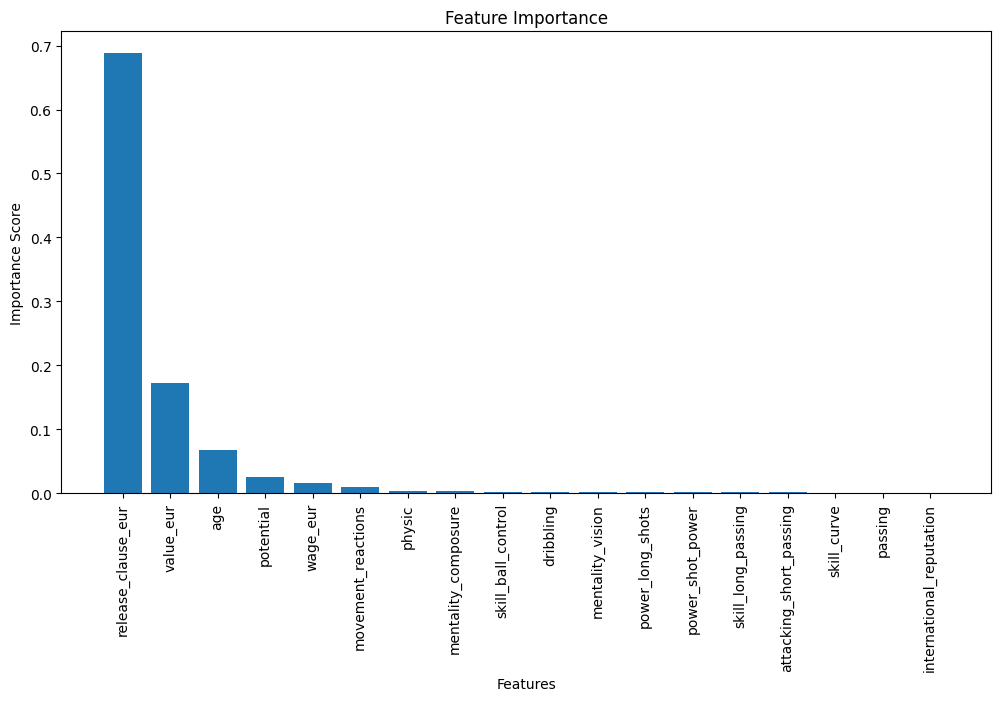

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_rf_model is the best RandomForest model after fine-tuning
feature_importances = best_rf_model.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Select top 5 features

In [48]:
# Select top N important features
top_n_features = 5
important_features = [features[i] for i in indices[:top_n_features]]
print(important_features)

# Update X to keep only the important features, but use the original X dataframe, not subset_df
X_important = X[important_features]  # Changed from subset_df to X
X_scaled_important = scaler.fit_transform(X_important)

# Now, X_scaled_important and y should have the same number of samples
X_train_important, X_test_important, y_train_important, y_test_important = train_test_split(
    X_scaled_important, y, test_size=0.2, random_state=42
)

['release_clause_eur', 'value_eur', 'age', 'potential', 'wage_eur']


In [49]:
subset_df[important_features].describe()

,release_clause_eur,value_eur,age,potential,wage_eur
count,6.517000e+03,6.517000e+03,6517.000000,6517.000000,6517.000000
mean,5.524458e+06,2.929169e+06,25.028234,72.454810,13379.357526
std,1.094654e+07,6.283350e+06,4.069244,5.426471,21517.135861
min,1.300000e+04,1.000000e+04,16.000000,53.000000,-5781.000000
25%,1.100000e+06,5.500000e+05,22.000000,69.000000,2000.000000
50%,2.231729e+06,1.200000e+06,25.000000,72.000000,6000.000000
75%,5.633559e+06,2.800000e+06,28.000000,76.000000,15000.000000
max,2.137000e+08,1.205000e+08,44.000000,91.000000,270000.000000


Train the random forest model

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train the RandomForest model again with important features
rf_model_important = RandomForestRegressor(n_estimators=best_rf_model.n_estimators,
                                           max_depth=best_rf_model.max_depth,
                                           min_samples_split=best_rf_model.min_samples_split,
                                           random_state=42)
rf_model_important.fit(X_train_important, y_train_important)

# Make predictions on the test set
rf_predictions_important = rf_model_important.predict(X_test_important)

# Evaluate the model using MAE and RMSE
rf_test_mae_important = mean_absolute_error(y_test_important, rf_predictions_important)
rf_test_rmse_important = np.sqrt(mean_squared_error(y_test_important, rf_predictions_important))

print("RandomForest Test MAE with Important Features: ", rf_test_mae_important)
print("RandomForest Test RMSE with Important Features: ", rf_test_rmse_important)

RandomForest Test MAE with Important Features:  0.7000536688090366
RandomForest Test RMSE with Important Features:  1.0947179939543425


Performance and fine-tuning

In [51]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Smaller hyperparameter grid for faster search
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Randomized Search with Cross-Validation
n_iter_search = 20

rf_random_search_important = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                                param_distributions=rf_param_grid,
                                                n_iter=n_iter_search,
                                                cv=kfold,
                                                scoring='neg_mean_absolute_error',
                                                n_jobs=-1,
                                                random_state=42)
rf_random_search_important.fit(X_train_important, y_train_important)

print("Best parameters for RandomForest: ", rf_random_search_important.best_params_)
print("Best cross-validation MAE for RandomForest: ", -rf_random_search_important.best_score_)

# Train the best RandomForest model with important features
best_rf_model_important = rf_random_search_important.best_estimator_
best_rf_model_important.fit(X_train_important, y_train_important)

# Make predictions on the test set
rf_predictions_important = best_rf_model_important.predict(X_test_important)

# Evaluate the model using MAE and RMSE
rf_test_mae_important = mean_absolute_error(y_test_important, rf_predictions_important)
rf_test_rmse_important = np.sqrt(mean_squared_error(y_test_important, rf_predictions_important))

print("RandomForest Test MAE with Important Features (after fine-tuning): ", rf_test_mae_important)
print("RandomForest Test RMSE with Important Features (after fine-tuning): ", rf_test_rmse_important)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for RandomForest:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best cross-validation MAE for RandomForest:  0.7295888121235832
RandomForest Test MAE with Important Features (after fine-tuning):  0.7053136042576607
RandomForest Test RMSE with Important Features (after fine-tuning):  1.1008787138438778


Use data from another season to test the model

In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def evaluate_model_with_new_data(filename, best_rf_model, important_features, scaler):
    # Load the new dataset
    df = pd.read_csv(filename)  # Modify as needed based on your file format

    # Assuming 'overall' is the target variable
    X_22 = df[important_features]  # Use the same important features

    # Impute missing values in X_22 if any
    imputer = SimpleImputer(strategy='mean')  # You can use other strategies as well
    X_22_imputed = imputer.fit_transform(X_22)

    # Scale the independent variables using the provided scaler
    X_scaled_22 = scaler.transform(X_22_imputed)  # Assuming 'scaler' is already fitted

    # Make predictions using the best RandomForest model
    rf_predictions_22 = best_rf_model.predict(X_scaled_22)

    # Calculate evaluation metrics (MAE and RMSE)
    # Assuming 'y_22' is the actual target values from the new dataset
    y_22 = df['overall']  # Adjust this based on your dataset structure

    mae_22 = mean_absolute_error(y_22, rf_predictions_22)
    rmse_22 = np.sqrt(mean_squared_error(y_22, rf_predictions_22))

    # Display informative messages
    print(f"Evaluation results for dataset '{filename}':")
    print(f"Mean Absolute Error (MAE): {mae_22:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_22:.4f}")
    print("\nPredictions:")
    print(rf_predictions_22)

    return rf_predictions_22, mae_22, rmse_22

# Example usage:
# Assuming 'best_rf_model_important', 'important_features', and 'scaler' are defined previously
filename = '/content/players_22 (1).csv'
predictions, mae, rmse = evaluate_model_with_new_data(filename, best_rf_model_important, important_features, scaler)


Evaluation results for dataset '/content/players_22 (1).csv':
Mean Absolute Error (MAE): 1.1001
Root Mean Squared Error (RMSE): 1.8403

Predictions:
[88.96 89.44 86.19 ... 53.16 53.93 53.57]


<ipython-input-52-8568232035fb>:10: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)  # Modify as needed based on your file format
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Save model as pickle file

In [53]:
import joblib

# Assuming best_rf_model is your trained RandomForestRegressor model
joblib.dump(best_rf_model_important, 'bestmodel1.pkl')

['bestmodel1.pkl']